<a href="https://colab.research.google.com/github/gugi200/final_project/blob/main/project_y4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install wandb -qU
!wandb login 3014974e724f01c4d63f956fa13fd7f0463e16d4

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
!pip install torchmetrics
!pip install mlxtend>=0.19.0
!pip list | grep mlx

mlxtend                          0.22.0


In [ ]:
#
#   Michael Gugala
#   02/12/2023
#   Image recognition
#   Master 4th year project
#   Univeristy of Bristol
#

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

import torchvision
from torchvision import datasets#
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchmetrics
from torchvision.models import resnet50, ResNet50_Weights
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix
from sklearn.utils import Bunch

from PIL import Image

from pathlib import Path

import wandb
import cv2
from timeit import default_timer as timer
from tqdm.auto import tqdm

# check imports
print(torch.__version__)
print(torchvision.__version__)

#agnostic code
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

2.1.0+cu118
0.16.0+cu118


'cuda'

In [ ]:
# downloiad test data
from torchvision.datasets import FashionMNIST
from torchvision import transforms

train_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=True,
    target_transform=None)

test_data = FashionMNIST(
    root='~/.pytorch/F_MNIST_data',
    download=True,
    train=False,
    target_transform=None)

class_names = [x.replace('/', '_').replace('-', '') for x in train_data.classes]

transform = transforms.ToPILImage()



from pathlib import Path

data_path = Path("data/")
image_path1 = data_path / "FashionMNIST" / "train"

if image_path1.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path1 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (train_img, target) in enumerate(zip(train_data.data[:1000], train_data.targets[:1000])):
        train_data_PIL = transform(train_img)
        file = "data_" + str(idx) + '.jpg'
        # print(target)
        # print(data_path / "FashionMNIST"/"train" / class_names[target] /file)
        train_data_PIL.save(data_path / "FashionMNIST"/"train" / class_names[target] /file)


data_path = Path("data/")
image_path2 = data_path / "FashionMNIST" / "test"
if image_path2.is_dir():
    print('directory already exists')
else:
    print('creating folder')
    for class_name in class_names:
        image_class_path = image_path2 / class_name
        image_class_path.mkdir(parents=True, exist_ok=True)
        image_class_path.mkdir(parents=True, exist_ok=True)

    for idx, (test_img, target) in enumerate(zip(test_data.data[:250], test_data.targets[:250])):
        test_data_PIL = transform(test_img)
        file = "data_" + str(idx) + '.jpg'
        test_data_PIL.save(data_path / "FashionMNIST"/"test" / class_names[target] /file)





directory already exists
directory already exists


# Plan of action
A.
1. Create different CNN models
    * a few of my own making
    * restnet
    * maybe something else
2. Train them on MNIST fashion data scaled to 24x24
3. a Loop to find the best hyperparameters

B. Create SVM models in scikit learn
1. Create a pipeline with different hyper parameters


# Prepare data
* trasnform to tensors
* upscale to 256 (restnet size)
* normalize (apply different normalization)

In [ ]:
preprocess = transforms.Compose([

    transforms.Resize(size=(224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.25, 0.25, 0.25], std=[0.1, 0.1, 0.1]),
])

train_data = datasets.ImageFolder(root=Path("data/FashionMNIST/train"),
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label


test_data = datasets.ImageFolder(root=Path("data/FashionMNIST/test"),
                                 transform=preprocess, # tranform for the data
                                  target_transform=None) # transform for label
class_names = train_data.classes

torch.Size([32, 3, 224, 224]) torch.Size([32])


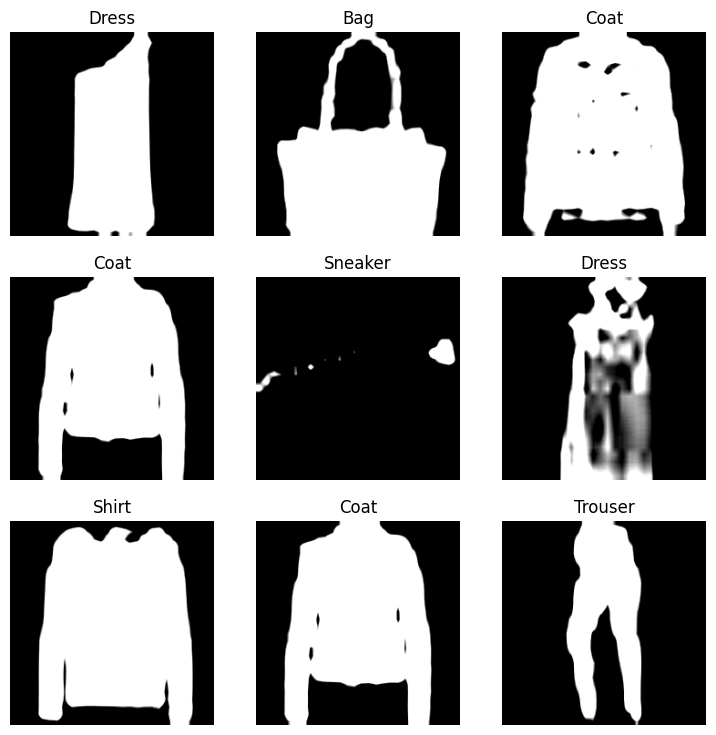

In [ ]:
# split data into batches
from torch.utils.data import DataLoader
BATCH_SIZE = 32

# turn datasets into iterables (batches)
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True) #  shuffling to remove order

test_dataloader = DataLoader(dataset=test_data,
                              batch_size=BATCH_SIZE,
                              shuffle=False) # here it doesn't matter, no point to waste resources


# iter tranforms it into iterable, next accesses the next batch
train_features_batch, train_labels_batch = next(iter(train_dataloader))
print(train_features_batch.shape, train_labels_batch.shape)

# display random datapoints
fig = plt.figure(figsize=(9, 9))
rows, cols  = 3, 3
for pic in range(1, 1+rows*cols):
    rand_int = np.random.randint(0, BATCH_SIZE)
    img = train_features_batch[rand_int]
    img_RGB = img.permute([1, 2, 0]).numpy()
    fig.add_subplot(rows, cols, pic)
    plt.imshow(img_RGB.squeeze())
    plt.axis(False)
    plt.title(class_names[train_labels_batch[rand_int]])





# Create models



## RestNet

### Create training loop

create dataset

In [ ]:
from pickle import NONE
# create data set from a custom data
def create_dataset(path, batchsize, mean=None, std=None):
    '''
    input:
    path - path to the folder with the data
           eg for train - "data/FashionMNIST/train"
    batchsize - eg 32
    mean (optional)- for normalization eg. [0.25, 0.25, 0.25]
    std (optional)- for nortmalization eg [0.1, 0.1, 0.1]

    returns:
    dataloader with image size of 224
    class_names
    '''
    if mean:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=mean, std=std),
        ])
    else:
        preprocess = transforms.Compose([

            transforms.Resize(size=(224, 224)),
            transforms.ToTensor()
        ])


    data = datasets.ImageFolder(root=Path(path),
                                    transform=preprocess, # tranform for the data
                                    target_transform=None) # transform for label
    dataloader = DataLoader(dataset=data,
                                batch_size=batchsize,
                                shuffle=True) #  shuffling to remove order
    class_names = data.classes
    return dataloader, class_names

# visdualize 9 random images in a batch
def visualise_data(dataloader, class_names, batchsize):
    '''
    input dataloader
    class names

    displays 9 random images in a batch and their labels
    '''
    train_features_batch, train_labels_batch = next(iter(dataloader))
    print("length of data: ", len(train_features_batch), 'length of labels: ', len(train_labels_batch))
    # display random datapoints
    fig = plt.figure(figsize=(9, 9))
    rows, cols  = 3, 3
    for pic in range(1, 1+rows*cols):
        rand_int = np.random.randint(0, batchsize)
        img = train_features_batch[rand_int]
        img_RGB = img.permute([1, 2, 0]).numpy()
        fig.add_subplot(rows, cols, pic)
        plt.imshow(img_RGB.squeeze())
        plt.axis(False)
        plt.title(class_names[train_labels_batch[rand_int]])


# create optimizer
def create_optiimizer(model, optimizer, lr):
    '''
    inputs:
    model - CNN network
    optimizer - "adam" or "sgd"
    lr - learning rate eg. 0.01

    '''
    if optimizer=='adam':
        optimizer = torch.optim.Adam(model.parameters(),
                                     lr=lr
                                     )
    elif optimizer=='sgd':
        optimizer = torch.optim.SGD(model.parameters(),
                                     lr=lr,
                                    momentum=0.9
                                     )

    return optimizer


def get_lossFn():
    '''
        returns CrossEntropyLoss function
    '''

    return nn.CrossEntropyLoss()

# create train step
def train_step(model, metric, loss_fn, optimizer,
               data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    optimizer - optimizer to be applied
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    train_loss - average loss of the batch
    train_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    train_loss, train_acc = 0, 0

    model.train()
    for batch, (X, y) in enumerate(data_loader):
        # put data on the device
        X, y = X.to(device), y.to(device)

        #forward pass, return raw logits
        y_pred = model(X)

        #loss
        loss = loss_fn(y_pred, y)
        #accuracy
        acc = metric(y, torch.argmax(y_pred, dim=1))

        train_loss += loss # accumulate train loss
        train_acc += acc # accumulate train accuracy

        # zero grad
        optimizer.zero_grad()

        # loss bacward
        loss.backward()

        #optimizer step
        optimizer.step()

        # log in wandb
        if wnb:
            wandb.log({"loss": loss,
                       'accuracy': acc})

    # device total loss and accuracy by length of train dataloader
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    if debug:
        print(f'Train loss: {train_loss:.4f}, Train acc: {train_acc*100:0.4f}%')

    return train_loss, train_acc


# create test step
def test_step(model, metric, loss_fn, data_loader, device, debug=False, wnb=True):
    '''
    model - CNN network
    metric - metric to calculate accuracy
    loss_fn - loss function
    data_loader - dataloader
    device - decide for the model to train
    debug (optional)- if True prints average loss and metric of the batch

    returns
    test_loss - average loss of the batch
    test_acc - average metric score of the batch

    The function saves the metric score and loss of each iteration in WandB

    '''
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X_test, y_test in data_loader:
            X_test, y_test = X_test.to(device), y_test.to(device)
            #1 forward pass
            test_pred = model(X_test)

            # calculate loss
            loss = loss_fn(test_pred, y_test)
            test_loss += loss

            #accuracy
            acc = metric(y_test, test_pred.argmax(dim=1))
            test_acc += acc

            if wnb:
                wandb.log({"test loss": loss,
                           'test accuracy': acc})

        # Calculate the test loss average batch
        test_loss /= len(data_loader)

        # acc per bactch
        test_acc /= len(data_loader)

        # Print out what's happening
        if debug:
            print(f'Test loss: {test_loss:.4f}  |  Test acc: {test_acc*100:.4f}%')

        return test_loss, test_acc

# create evaluation loop
def eval_model(model: torch.nn.Module,
                data_loader: torch.utils.data.DataLoader,
                loss_fn: torch.nn.Module,
                accuracy_fn,
               device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(data_loader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)

            #accumulate the loss and acc
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))

        # ave loss and acc
        loss /= len(data_loader)
        acc /= len(data_loader)
    return {"model_name": model.__class__.__name__, # only works if a model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc.item()*100}




def visualize_preds(model, dataloader, class_names, batchsize):
    plt.figure(figsize=(9, 9))
    nrows = 3
    ncols = 3
    model = model.cpu()

    dataL_len = len(dataloader)
    data = iter(dataloader)
    for i in range(3):
        model.eval()
        with torch.inference_mode():

            X, y = next(data)
            X, y = X.cpu(), y.cpu()
            for j in range(3):
                randint = np.random.randint(0, batchsize)
                X_sample, y_sample = X[randint], y[randint]
                pred_logit = model(X_sample.unsqueeze(dim=0))

                pred_prob = pred_logit.argmax(dim=1)


                plt.subplot(nrows, ncols, (3*i)+j+1);
                plt.imshow(X_sample.squeeze().permute([1, 2, 0]), cmap='gray');

                #find pred_label in text form
                pred_label = class_names[pred_prob];

                # find truth label
                truth_label = class_names[y_sample];

                title_text = f'Pred: {pred_label}  \n  Truth: {truth_label}'

                if pred_label==truth_label:
                    plt.title(title_text, fontsize=10, c='g');
                else:
                    plt.title(title_text, fontsize=10, c='r');
                plt.axis(False)
                plt.tight_layout()



def plot_decision_matrix(class_names, y_pred_tensor, targets):
    # setup confusion matrix
    confmat = ConfusionMatrix(num_classes=len(class_names), task='multiclass')
    confmat_tensor = confmat(preds=y_pred_tensor,
                            target=targets)

    # plot consufionmatrix
    fig, ax = plot_confusion_matrix(
        conf_mat=confmat_tensor.numpy(),
        class_names=class_names,
        figsize=(10, 7)
    )

def make_predictions(model, data, device):
    model.eval()
    data = data.to(device)
    model = model.to(device)
    with torch.inference_mode():
        y_preds = model(data)
    return y_preds.cpu()


def dataloader_to_numpy(dataloader):
    for i, (data, target) in enumerate(dataloader):
        if i==0:
            data_numpy = data.numpy()
            target_numpy = target.numpy()
        else:
            data_numpy = np.append(data_numpy, data.numpy(), axis=0)
            target_numpy = np.append(target_numpy, target.numpy(), axis=0)
    return data_numpy, target_numpy


def get_datalodaer(batchsize):

    train_dataloader, class_names = create_dataset(
                                        path="data/FashionMNIST/train",
                                        batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    test_dataloader, _ = create_dataset(
                                path="data/FashionMNIST/test",
                                batchsize=batchsize,
                                    mean=[0.485, 0.456, 0.406],
                                    std=[0.229, 0.224, 0.225]
                                    )
    return train_dataloader, test_dataloader, class_names


def train_test_loop(config, model, train_dataloader, test_dataloader,
                    class_names):
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=config.optimizer,
                                    lr=config.learning_rate
    )
    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in range(config.epochs):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            debug=True
        )
        wandb.log({"average train batch loss": ave_batch_loss,
                    "average train batch metric": ave_batch_metric,
                    "average test batch loss": ave_batch_loss,
                    "average test batch metric": ave_batch_metric,
                    "epoch": epoch
                    })
    train_time_end = timer()
    wandb.log({"train time": train_time_end - train_time_start})



## First test loop
test on FashionMNIST with a loop of different hyper parammeters and wandb experiment result collection

length of data:  64 length of labels:  64


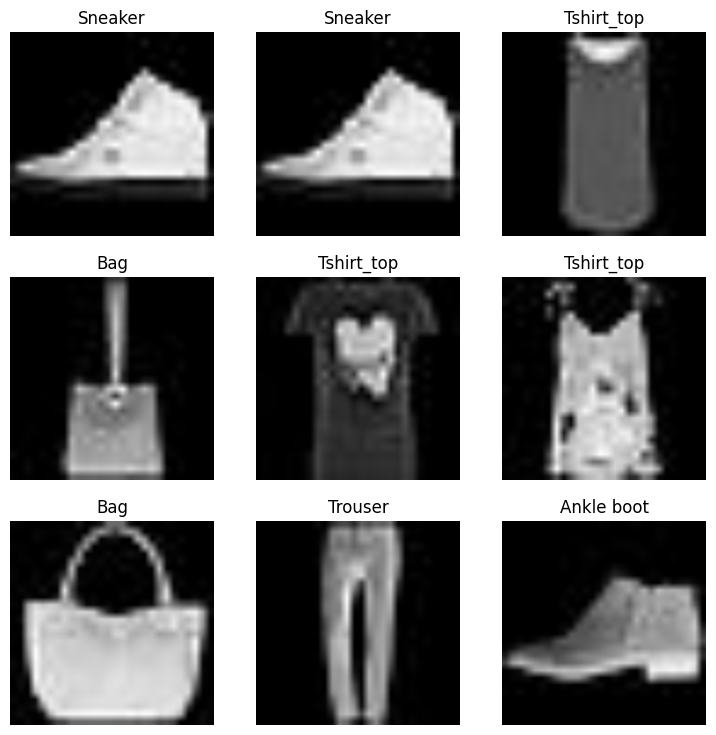

In [ ]:
batchsize = 64
train_dataloader, class_names = create_dataset(
                                     path="data/FashionMNIST/train",
                                     batchsize=batchsize
                                     )
test_dataloader, _ = create_dataset(
                             path="data/FashionMNIST/test",
                             batchsize=batchsize
                             )

visualise_data(dataloader=train_dataloader, class_names=class_names, batchsize=batchsize)

cuda


  0%|          | 0/10 [00:00<?, ?it/s]

Train loss: 1.1725, Train acc: 60.2539%
Test loss: 3.2488  |  Test acc: 42.7885%
Train loss: 0.5539, Train acc: 79.2969%
Test loss: 0.7815  |  Test acc: 69.8017%
Train loss: 0.4368, Train acc: 84.5703%
Test loss: 0.7163  |  Test acc: 77.1034%
Train loss: 0.3383, Train acc: 87.8906%
Test loss: 0.6544  |  Test acc: 76.6226%
Train loss: 0.2118, Train acc: 92.7734%
Test loss: 0.5588  |  Test acc: 82.7524%
Train loss: 0.1315, Train acc: 95.7031%
Test loss: 0.6527  |  Test acc: 82.4519%
Train loss: 0.1619, Train acc: 94.2383%
Test loss: 0.7566  |  Test acc: 83.4135%
Train loss: 0.2447, Train acc: 91.6016%
Test loss: 0.5898  |  Test acc: 83.7139%
Train loss: 0.1793, Train acc: 93.4570%
Test loss: 0.6207  |  Test acc: 81.4904%
Train loss: 0.0999, Train acc: 96.4844%
Test loss: 0.6010  |  Test acc: 84.3149%


<ipython-input-8-4ff76bd0e397>:250: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(nrows, ncols, (3*i)+j+1);


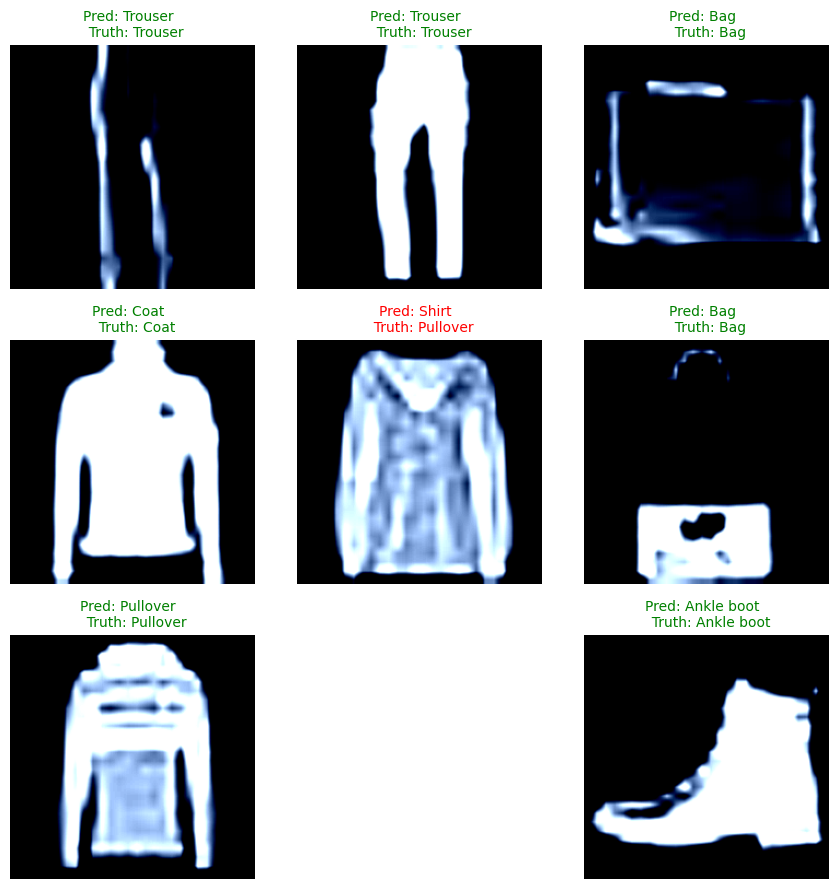

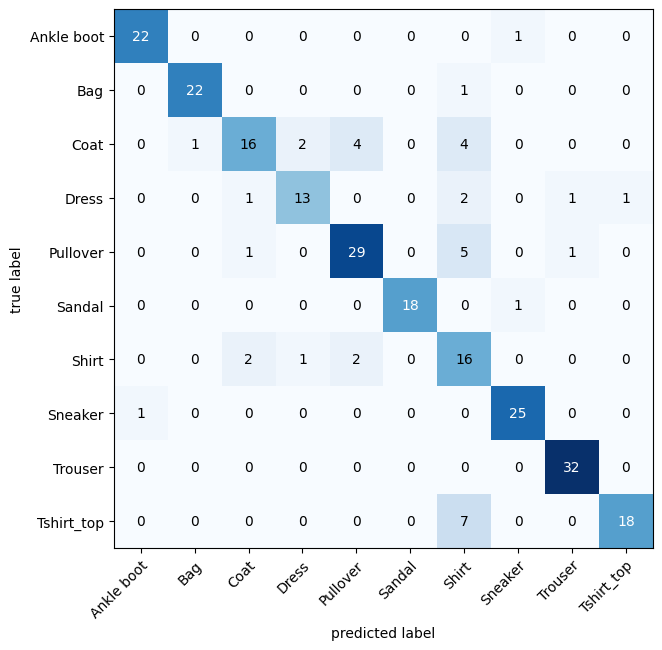

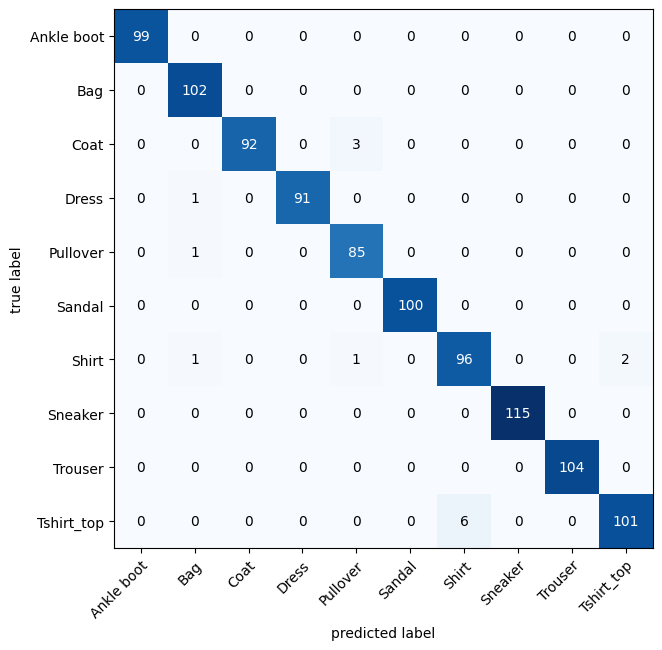

In [ ]:
# test with no hyperparameter sweeping
torch.manual_seed(42)
torch.cuda.manual_seed(42)
from torchvision.models import resnet50, ResNet50_Weights

# get data
train_dataloader, class_names = create_dataset(
                                    path="data/FashionMNIST/train",
                                    batchsize=32,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )
test_dataloader, _ = create_dataset(
                            path="data/FashionMNIST/test",
                            batchsize=32,
                                mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]
                                )

# get model
model = resnet50(weights=ResNet50_Weights.DEFAULT)
model.fc = nn.Linear(2048, 10)


def train_model_restent50(train_dataloader, test_dataloader, lr, optimizer, batchsize, epochs, class_names, model):
    print(device)

    model = model.to(device)
    loss_fn = get_lossFn()
    optimizer = create_optiimizer(model=model,
                                    optimizer=optimizer,
                                    lr=lr
    )


    metric = torchmetrics.classification.Accuracy(
        task="multiclass",
        num_classes=len(class_names)
    ).to(device)
    train_time_start = timer()
    for epoch in tqdm(range(epochs)):
        ave_batch_loss, ave_batch_metric = train_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            optimizer=optimizer,
            data_loader=train_dataloader,
            device=device,
            wnb=False,
            debug=True
        )
        ve_batch_loss, ave_batch_metric = test_step(
            model=model,
            metric=metric,
            loss_fn=loss_fn,
            data_loader=test_dataloader,
            device=device,
            wnb=False,
            debug=True
        )

    train_time_end = timer()

    return model

newModel = train_model_restent50(train_dataloader=train_dataloader,
                                 test_dataloader=test_dataloader,
                                 lr=0.001,
                                 optimizer='adam',
                                 batchsize=32,
                                 epochs=10,
                                 class_names=class_names,
                                 model=model).cpu()

visualize_preds(model=newModel,
                dataloader=test_dataloader,
                class_names=class_names,
                batchsize=32)

data_test_numpy, target_test_numpy = dataloader_to_numpy(test_dataloader)

y_test_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_test_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_test_preds_tensor,
                     targets=torch.tensor(target_test_numpy))


data_train_numpy, target_train_numpy = dataloader_to_numpy(train_dataloader)

y_train_preds_tensor = make_predictions(model=newModel,
                           data=torch.tensor(data_train_numpy),
                           device=device
                        )

plot_decision_matrix(class_names=class_names,
                     y_pred_tensor=y_train_preds_tensor,
                     targets=torch.tensor(target_train_numpy))



In [ ]:

torch.manual_seed(42)
torch.cuda.manual_seed(42)


sweep_config = {
    'method': 'random'
    }
metric = {
    'name': 'loss',
    'goal': 'minimize'
    }
sweep_config['metric'] = metric

parameters_dict = {
    'optimizer': {
        'values': ['adam', 'sgd']
        },
    'fc_layer_size': {
        'values': [10]
        },
    }

sweep_config['parameters'] = parameters_dict

parameters_dict.update({
    'epochs': {
        'value': 2}
    })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'distribution': 'uniform',
        'min': 0,
        'max': 0.1
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'distribution': 'q_log_uniform_values',
        'q': 8,
        'min': 8,
        'max': 32,
      }
    })

parameters_dict.update({
    'learning_rate': {
        # a flat distribution between 0 and 0.1
        'values': [0.001, 0.005, 0.01, 0.05, 0.1]
      },
    'batch_size': {
        # integers between 32 and 256
        # with evenly-distributed logarithms
        'values': [8, 16, 24]
      }
    })



import pprint
pprint.pprint(sweep_config)


def train_model_resnet50(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        model = resnet50(
            weights=ResNet50_Weights.DEFAULT).to(device)
        model.fc = nn.Linear(2048 , config.fc_layer_size).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_alexnet(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('alexnet'))[-1]
        model = torch.hub.load('pytorch/vision', 'alexnet', weight).to(device)
        model.classifier[6] = nn.Linear(4096 , 10).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_convnext_base(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('convnext_base'))[-1]
        model = torch.hub.load('pytorch/vision', 'convnext_base', weight).to(device)
        model.classifier[2] = nn.Linear(1024 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_densenet161(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('densenet161'))[-1]
        model = torch.hub.load('pytorch/vision', 'densenet161', weight).to(device)
        model.classifier = nn.Linear(2208 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_efficientnet_v2_l(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('efficientnet_v2_l'))[-1]
        model = torch.hub.load('pytorch/vision', 'efficientnet_v2_l', weight).to(device)
        model.classifier[1] = nn.Linear(1280 , 10, bias=True).to(device).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_googlenet(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('googlenet'))[-1]
        model = torch.hub.load('pytorch/vision', 'googlenet', weight).to(device)
        model.fc = nn.Linear(1024 , 10, bias=True).to(device)
        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_inception_v3(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('inception_v3'))[-1]
        model = torch.hub.load('pytorch/vision', 'inception_v3', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_maxvit_t(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('maxvit_t'))[-1]
        model = torch.hub.load('pytorch/vision', 'maxvit_t', weight).to(device)
        model.classifier[5] = nn.Linear(512 , 10, bias=False).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_mobilenet_v3_large(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('mobilenet_v3_large'))[-1]
        model = torch.hub.load('pytorch/vision', 'mobilenet_v3_large', weight).to(device)
        model.classifier[3] = nn.Linear(1280 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model


def train_model_shufflenet_v2_x2_0(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('shufflenet_v2_x2_0'))[-1]
        model = torch.hub.load('pytorch/vision', 'shufflenet_v2_x2_0', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_swin_v2_t(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('swin_v2_t'))[-1]
        model = torch.hub.load('pytorch/vision', 'swin_v2_t', weight).to(device)
        model.head = nn.Linear(768 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_vgg19_bn(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('vgg19_bn'))[-1]
        model = torch.hub.load('pytorch/vision', 'vgg19_bn', weight).to(device)
        model.classifier[6] = nn.Linear(4096 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model

def train_model_wide_resnet50_2(config=None):
    with wandb.init(config=config):
        config = wandb.config

        train_dataloader, test_dataloader, class_names = get_datalodaer(
            batchsize=config.batch_size)

        weight = list(torchvision.models.get_model_weights('wide_resnet50_2'))[-1]
        model = torch.hub.load('pytorch/vision', 'wide_resnet50_2', weight).to(device)
        model.fc = nn.Linear(2048 , 10, bias=True).to(device)

        train_test_loop(config=config,
                        model=model,
                        train_dataloader=train_dataloader,
                        test_dataloader=test_dataloader,
                        class_names=class_names
                        )
    return model


count=1

sweep_id_restnet50 = wandb.sweep(sweep_config, project="restnet-test")
wandb.agent(sweep_id_restnet50, train_model_resnet50, count=count)

sweep_id_alexnet = wandb.sweep(sweep_config, project="alexnet-test")
wandb.agent(sweep_id_alexnet, train_model_alexnet, count=count)

sweep_id_convnext_base = wandb.sweep(sweep_config, project="convnext_base-test")
wandb.agent(sweep_id_convnext_base, train_model_convnext_base, count=count)

sweep_id_densenet161 = wandb.sweep(sweep_config, project="densenet161-test")
wandb.agent(sweep_id_densenet161, train_model_densenet161, count=count)

sweep_id_efficientnet_v2_l = wandb.sweep(sweep_config, project="efficientnet_v2_l-test")
wandb.agent(sweep_id_efficientnet_v2_l, train_model_efficientnet_v2_l, count=count)

sweep_id_googlenet = wandb.sweep(sweep_config, project="googlenet-test")
wandb.agent(sweep_id_googlenet, train_model_googlenet, count=count)

sweep_id_inception_v3 = wandb.sweep(sweep_config, project="inception_v3-test")
wandb.agent(sweep_id_inception_v3, train_model_inception_v3, count=count)

sweep_id_maxvit_t = wandb.sweep(sweep_config, project="maxvit_t-test")
wandb.agent(sweep_id_maxvit_t, train_model_maxvit_t, count=count)

sweep_id_mobilenet_v3_large = wandb.sweep(sweep_config, project="mobilenet_v3_large-test")
wandb.agent(sweep_id_mobilenet_v3_large, train_model_mobilenet_v3_large, count=count)

sweep_id_shufflenet_v2_x2_0 = wandb.sweep(sweep_config, project="shufflenet_v2_x2_0-test")
wandb.agent(sweep_id_shufflenet_v2_x2_0, train_model_shufflenet_v2_x2_0, count=count)

sweep_id_swin_v2_t = wandb.sweep(sweep_config, project="swin_v2_t-test")
wandb.agent(sweep_id_swin_v2_t, train_model_swin_v2_t, count=count)

sweep_id_vgg19_bn = wandb.sweep(sweep_config, project="vgg19_bn-test")
wandb.agent(sweep_id_vgg19_bn, train_model_vgg19_bn, count=count)

sweep_id_wide_resnet50_2 = wandb.sweep(sweep_config, project="wide_resnet50_2-test")
wandb.agent(sweep_id_wide_resnet50_2, train_model_wide_resnet50_2, count=count)



{'method': 'random',
 'metric': {'goal': 'minimize', 'name': 'loss'},
 'parameters': {'batch_size': {'values': [8, 16, 24]},
                'epochs': {'value': 2},
                'fc_layer_size': {'values': [10]},
                'learning_rate': {'values': [0.001, 0.005, 0.01, 0.05, 0.1]},
                'optimizer': {'values': ['adam', 'sgd']}}}
Create sweep with ID: eeiuvrzq
Sweep URL: https://wandb.ai/gugi200/restnet-test/sweeps/eeiuvrzq


wandb: Agent Starting Run: a5z1vlcw with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Train loss: 1.8906, Train acc: 39.4345%
Test loss: 1.2884  |  Test acc: 61.5152%
Train loss: 0.7121, Train acc: 77.4802%
Test loss: 0.5780  |  Test acc: 80.6818%


accuracy,▁▂▁▁▂▁▃▃▃▃▄▅▄▄▄▆▃▅▅▆▆▇▆▅▆▆▆▄▆▇█▅▇▆▆▆▆▆▇▇
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,██████▇█▇▇▇▆▆▆▆▅▆▅▄▄▄▃▃▃▃▂▃▄▃▂▁▃▂▃▃▂▃▂▂▁
test accuracy,▄▃▆▄▁▄▃▄▂▄▃▆▆▅▇▅▅▅▄▆▆█
test loss,▆▇▇▇█▇█▇█▅▇▁▂▄▂▂▃▃▃▃▂▁
train time,▁
accuracy,0.875


Create sweep with ID: w13x8o3p
Sweep URL: https://wandb.ai/gugi200/alexnet-test/sweeps/w13x8o3p


wandb: Agent Starting Run: m41oisy2 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.05
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Train loss: nan, Train acc: 9.8214%
Test loss: nan  |  Test acc: 9.9219%
Train loss: nan, Train acc: 9.9206%
Test loss: nan  |  Test acc: 9.4531%


accuracy,▁▄▄▂▂▁▂▄▄▂▅▁▂▂▇▄▂▂▄▁▂▇▅█▂▄▂▁▂▄▄▁▂▄▂▅▅▁▁▄
average test batch metric,█▁
average train batch metric,█▁
epoch,▁█
loss,▁█
test accuracy,▁▃▂▁▁▂▃▃▃▄▄▂▂▁▂█▄▃▃▁▁▃▂▁▂▁▂▅▂▃▃▅
train time,▁
accuracy,0.125
average test batch loss,nan
average test batch metric,0.09453
average train batch loss,nan


Create sweep with ID: fi095acp
Sweep URL: https://wandb.ai/gugi200/convnext_base-test/sweeps/fi095acp


wandb: Agent Starting Run: e5hvcaup with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.05
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 4.5303, Train acc: 8.1000%
Test loss: 2.6990  |  Test acc: 7.4219%
Train loss: 2.5468, Train acc: 10.6000%
Test loss: 2.4994  |  Test acc: 8.9844%


accuracy,▁▁▃▃▃▁▁▁▃▃▃▁▃▁▁▃▁█▃▆▃▁▁▃▁▃▁▃▆▆▆▃▃▁▆▃▁▁▁▃
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,▁▆█▂▂▂▂▂▂▁▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test accuracy,▃▁▃▃▁▆▁▆▃█▁▁▃▁▃▁▁▁▃▃▁▁▁▃▁▃▃▁▆▃▃▃▃▁▃▆▁▃█▁
test loss,▄▆▃▄▆▂▅▆▆▁▄█▅▇▅▅▄▇▄▄▄▃▅▄▅▃▄▅▂▄▄▃▅▅▄▃▆▄▂▆
train time,▁
accuracy,0.25


Create sweep with ID: 7mqzvvcz
Sweep URL: https://wandb.ai/gugi200/densenet161-test/sweeps/7mqzvvcz


wandb: Agent Starting Run: xnp3l2gd with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 1.1027, Train acc: 62.6488%
Test loss: 0.6081  |  Test acc: 78.7879%
Train loss: 0.4711, Train acc: 83.8790%
Test loss: 0.4936  |  Test acc: 82.5000%


accuracy,▁▂▂▅▅▄▆▆▆▇▆▇█▆▅▆▇▆▆▇▆▆█▇▇▇▇███▇▇▆▇▇█▇▇▇▇
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,███▆▆▅▄▃▄▃▃▂▂▃▄▃▂▂▃▂▂▃▁▁▁▃▂▁▂▁▂▂▃▃▂▁▂▂▂▂
test accuracy,▁▇▂▅▃▂▁▁▁▁█▃▆▄▄▄▃▃▅▅▄▁
test loss,▅▁▄▂▄▅█▅▆▇▁▅▂▄▃▃▅▄▃▃▃▄
train time,▁
accuracy,0.8125


Create sweep with ID: v2s0dbq3
Sweep URL: https://wandb.ai/gugi200/efficientnet_v2_l-test/sweeps/v2s0dbq3


wandb: Agent Starting Run: x574v9qy with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-15-8cd63324298f>", line 152, in train_model_efficientnet_v2_l
    train_test_loop(config=config,
  File "<ipython-input-14-0011a81331ed>", line 333, in train_test_loop
    ave_batch_loss, ave_batch_metric = train_step(
  File "<ipython-input-14-0011a81331ed>", line 119, in train_step
    y_pred = model(X)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/efficientnet.py", line 343, in forward
    return self._forward_impl(x)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/efficientnet.py", line 333, in _forward_impl
    x = self.features(x

Run x574v9qy errored: RuntimeError('Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same')
wandb: ERROR Run x574v9qy errored: RuntimeError('Input type (torch.cuda.FloatTensor) and weight type (torch.FloatTensor) should be the same')


Create sweep with ID: g6ym07nw
Sweep URL: https://wandb.ai/gugi200/googlenet-test/sweeps/g6ym07nw


wandb: Agent Starting Run: csfyw3dc with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 1.6469, Train acc: 39.5337%
Test loss: 15.7282  |  Test acc: 12.1212%
Train loss: 1.2406, Train acc: 52.8770%
Test loss: 1.2386  |  Test acc: 52.1212%


accuracy,▁▂▄▃▃▅▄▅▁▄▃▄▄▂▅▇▄▅▄▄▄▇▅▄▄▅▆▅▅▄▄▄▅▅▅▅▅▅▆█
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,▆█▅▅▅▄▄▃▄▄▃▄▄▄▃▃▄▃▃▄▄▃▃▄▅▄▃▃▃▃▃▃▃▂▃▂▄▃▃▁
test accuracy,▃▃▂▂▂▂▁▂▂▄▁█▇▅▇▆▆█▅▇▇▅
test loss,▆▅▇▇▇▅▇▅█▆█▁▁▁▁▁▁▁▁▁▁▁
train time,▁
accuracy,0.875


Create sweep with ID: u98nafl1
Sweep URL: https://wandb.ai/gugi200/inception_v3-test/sweeps/u98nafl1


wandb: Agent Starting Run: oq75w3gt with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.05
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-15-8cd63324298f>", line 189, in train_model_inception_v3
    train_test_loop(config=config,
  File "<ipython-input-14-0011a81331ed>", line 333, in train_test_loop
    ave_batch_loss, ave_batch_metric = train_step(
  File "<ipython-input-14-0011a81331ed>", line 119, in train_step
    y_pred = model(X)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1518, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1527, in _call_impl
    return forward_call(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py", line 166, in forward
    x, aux = self._forward(x)
  File "/usr/local/lib/python3.10/dist-packages/torchvision/models/inception.py", line 138, in _forward
    aux = self.AuxLogits(x)
  File "/usr/l

Run oq75w3gt errored: RuntimeError("Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size")
wandb: ERROR Run oq75w3gt errored: RuntimeError("Calculated padded input size per channel: (3 x 3). Kernel size: (5 x 5). Kernel size can't be greater than actual input size")


Create sweep with ID: 4fionxmp
Sweep URL: https://wandb.ai/gugi200/maxvit_t-test/sweeps/4fionxmp


wandb: Agent Starting Run: auk5wt4t with config:
wandb: 	batch_size: 16
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.05
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 16.4214, Train acc: 9.3254%
Test loss: 6.1639  |  Test acc: 13.2031%
Train loss: 9.1933, Train acc: 11.2103%
Test loss: 8.6874  |  Test acc: 9.7656%


accuracy,▂▁▁▄▅▂▂▅▂▁▂▂▇▁█▂▅▂▄▇▂▂▄▂▄▂▂▅▂▅▁▁▂▄▂▂▄▄▂▁
average test batch loss,█▁
average test batch metric,█▁
average train batch loss,█▁
average train batch metric,█▁
epoch,▁█
loss,▁▅▇▆▇▆█▆█▆▅▆▄▅▄▅▄▄▃▆▄▅▃▃▄▂▅▂▄▅▃▄▃▅▃▄▂▂▃▄
test accuracy,▄▂▂▇▂▄▄▂▂▄▄▄▅▅▄█▂▁▄▅▇▂▇▅▁▁▁▄▂▁▇▁
test loss,▂▁▄▁▅▅▇▅▁▃▆▂▄▂▇▄▄█▆▆▆█▄▅▇██▆▅█▅▆
train time,▁
accuracy,0.0


Create sweep with ID: c3lm2d15
Sweep URL: https://wandb.ai/gugi200/mobilenet_v3_large-test/sweeps/c3lm2d15


wandb: Agent Starting Run: sxydkgnz with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 2.2595, Train acc: 37.5000%
Test loss: 191.6883  |  Test acc: 12.5000%
Train loss: 1.4276, Train acc: 51.3000%
Test loss: 27.5099  |  Test acc: 16.0156%


accuracy,▂▁▁▅▃▂▂▅▁▃▄▇▇█▃▃▆▅▃▄▃▃▂▅▃▄▅▅▆▆▃▃█▅▅▄▅█▇▆
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,▅▇█▃▃▃▂▂▃▃▂▁▂▁▂▃▁▂▃▂▂▃▇▂▃▃▂▃▂▂▂▃▁▂▂▃▂▁▁▁
test accuracy,▁▁▁█▃▆▁▃▃▃▃▁▁▁▁▆▃▆▆▆▆▃▆█▁▃▆▃▃█▃▁▁▃▆▆▁▃▆▁
test loss,▇█▆▄▆▅▅▆▆▆▅▇██▇▆▆▅▅▇▂▂▁▁▂▂▁▂▂▁▂▂▂▁▂▁▂▂▂▁
train time,▁
accuracy,0.75


Create sweep with ID: 5pay5xxc
Sweep URL: https://wandb.ai/gugi200/regnet_y_400mf-test/sweeps/5pay5xxc


wandb: Agent Starting Run: 221iocsp with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-15-8cd63324298f>", line 244, in train_model_regnet_y_400mf
    model.fc[3] = nn.Linear(440 , 10, bias=True).to(device)
TypeError: 'Linear' object does not support item assignment


Run 221iocsp errored: TypeError("'Linear' object does not support item assignment")
wandb: ERROR Run 221iocsp errored: TypeError("'Linear' object does not support item assignment")
wandb: Agent Starting Run: n6ip0jyp with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.005
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main
Traceback (most recent call last):
  File "<ipython-input-15-8cd63324298f>", line 244, in train_model_regnet_y_400mf
    model.fc[3] = nn.Linear(440 , 10, bias=True).to(device)
TypeError: 'Linear' object does not support item assignment


Run n6ip0jyp errored: TypeError("'Linear' object does not support item assignment")
wandb: ERROR Run n6ip0jyp errored: TypeError("'Linear' object does not support item assignment")


Create sweep with ID: hh59t0zh
Sweep URL: https://wandb.ai/gugi200/shufflenet_v2_x2_0-test/sweeps/hh59t0zh


wandb: Agent Starting Run: qoosqu0v with config:
wandb: 	batch_size: 8
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.005
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 1.6247, Train acc: 45.8000%
Test loss: 6.3875  |  Test acc: 17.5781%
Train loss: 1.0419, Train acc: 63.1000%
Test loss: 1.0468  |  Test acc: 67.1875%


accuracy,▂▂▃▅▄▃▄▅▄▄▂▃▄▆█▃▆▅▆▄▄▃▂▆▄▆▄▁▅▄▆▇▄▆▇█▃▃▅▇
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,▇▇▆▅▄▅▄▅▅▆▆▇▄▂▂▅▃▃▃▄▃█▄▄▄▃▄▇▅▄▃▂▅▂▂▁▄▄▂▂
test accuracy,▁▂▃▃▂▂▂▃▄▁▃▁▃▂▃▁▃▂▃▂▃▇▃▆▆▆▅▇▆▅█▅▇▅▄▆▆▅▆▅
test loss,▄▆▄▅▅▇▆▄▂▄▄▅▄▆▅▅█▄▅▄▂▁▂▁▂▁▁▁▂▂▁▁▁▁▂▁▁▂▁▃
train time,▁
accuracy,0.625


Create sweep with ID: csiwloa8
Sweep URL: https://wandb.ai/gugi200/swin_v2_t-test/sweeps/csiwloa8


wandb: Agent Starting Run: w9trstkh with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.001
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 2.3265, Train acc: 13.0456%
Test loss: 2.1027  |  Test acc: 15.9091%
Train loss: 2.3161, Train acc: 14.6825%
Test loss: 2.3159  |  Test acc: 10.5303%


accuracy,▄▄▃▄▅▂▅▃▄▃▄▂▄▃▁▄▇▅▄▂▅▆▄▇▃▅▆█▄▄▄▁▄▄▄▅▄▂▃▄
average test batch loss,█▁
average test batch metric,█▁
average train batch loss,█▁
average train batch metric,█▁
epoch,▁█
loss,▃▅▃▃▃▃▃▃▃▃▃▃▃▃▃▃▂▂▂▄▃▂▂▂▃▃▁▁▂█▃▃▃▃▄▃▃▄▃▄
test accuracy,█▁█▆▆▃▅▇██▁▃▅▂▂▂▆█▁▅▃▇
test loss,▂▅▂▃▃▁▅▃▁▁▆▆▆▇██▇█▇▇█▇
train time,▁
accuracy,0.125


Create sweep with ID: t4janar2
Sweep URL: https://wandb.ai/gugi200/vgg19_bn-test/sweeps/t4janar2


wandb: Agent Starting Run: 4mdtm036 with config:
wandb: 	batch_size: 24
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.05
wandb: 	optimizer: adam


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 2325.7427, Train acc: 13.7897%
Test loss: 73881.2266  |  Test acc: 10.3788%
Train loss: 148.8855, Train acc: 15.3770%
Test loss: 1077.9272  |  Test acc: 19.6212%


accuracy,▂▄▂▅▂▃▃▅▁▂▆▃▁▆▃█▇▅▆▃▂▆▄▄▇▆▅▂▆▅▂▄▁▅▅▃▄▃▄▇
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,▁█▄▂▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
test accuracy,▁▁▃▅▅▃▁▅▁▃▃▃▆▇▃▇▃▅▇▅█▅
test loss,▇█▇▇▆██▇▆▇█▁▁▁▁▁▁▁▁▁▁▁
train time,▁
accuracy,0.25


Create sweep with ID: wmrp6go4
Sweep URL: https://wandb.ai/gugi200/wide_resnet50_2-test/sweeps/wmrp6go4


wandb: Agent Starting Run: mcr7l283 with config:
wandb: 	batch_size: 16
wandb: 	epochs: 2
wandb: 	fc_layer_size: 10
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd


Using cache found in /root/.cache/torch/hub/pytorch_vision_main


Train loss: 1.2788, Train acc: 54.5635%
Test loss: 0.6722  |  Test acc: 76.7188%
Train loss: 0.4889, Train acc: 83.3333%
Test loss: 0.6122  |  Test acc: 79.2188%


accuracy,▁▂▁▁▃▃▅▅▇▆▃▅▆▆▇▆▅▅▅▅▇▆▇▇▇█▅▇▇▅▇█▇▅▇▅▇▇█▆
average test batch loss,█▁
average test batch metric,▁█
average train batch loss,█▁
average train batch metric,▁█
epoch,▁█
loss,█▇▇█▇▆▅▅▃▃▆▃▃▃▃▂▄▃▃▃▁▃▂▂▂▁▃▂▁▄▂▁▂▃▂▂▃▁▁▂
test accuracy,▇▄▂▅▇▅▁▁▄▅▂▄▁▅▇▇▅▅▄█▇▂▄▅█▅▅▅▁▅▁▅
test loss,▂▄▅▃▃▄▅▆▇▄▅▄▄▃▂▃▄▄▃▁▂▃▄▃▂▄▂▄█▃▅▅
train time,▁
accuracy,0.75


In [ ]:
weight = list(torchvision.models.get_model_weights('inception_v3'))[-1]
model = torch.hub.load('pytorch/vision', 'inception_v3', weight).to(device)
model

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [ ]:
weight = list(torchvision.models.get_model_weights('regnet_y_400mf'))[-1]
model = torch.hub.load('pytorch/vision', 'regnet_y_400mf', weight).to(device)
print(model)
model.fc = nn.Linear(440 , 10, bias=True).to(device)

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 48, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(48, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(48, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=6, bias=False)
            

Using cache found in /root/.cache/torch/hub/pytorch_vision_main
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:135: UserWarning: Using 'weights' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(


# Testing different CNN models
* RestNet
* AlexNet
* VGGNet
* GoogLeNet/Inception
* DenseNet

In [ ]:
model_list = [
    'alexnet',
    'restnet50',
    'convnext_base',
    'densenet121', 'densenet161', 'densenet169', 'densenet201',
    'efficientnet_b4', 'efficientnet_v2_l',
    'googlenet',
    'inception_v3',
    'maxvit_t',
    'mobilenet_v3_large',
    'regnet_y_400mf',
    'shufflenet_v2_x2_0',
    'swin_v2_t',
    'vgg19', 'vgg19_bn','vgg13',
    'wide_resnet50_2']